# Results for performance measure

In [55]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['svg.fonttype'] = 'none'
#import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({'font.size': 12})
import scipy.stats as stats
from scipy.stats import mannwhitneyu

### Read and group data

In [56]:
#bundesLaender = ["berlin", "baden-württemberg", "brandenburg"]
bundesLaender = ["Berlin", "Baden-Württemberg", "Brandenburg"]

dataframes = {}
for bundesland in bundesLaender:
    # load the xes event log into a pandas dataframe
    dataframes[bundesland] = pm4py.read_xes('./all-data-xes/' + bundesland.lower() + '-all-preprocessed.xes')

parsing log, completed traces ::   0%|          | 0/105091 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/59458 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/69657 [00:00<?, ?it/s]

In [74]:
# select performance measure from the following list:
# "Cycle Time", "Inter-arrival Time", "Frequency", "Variants"
performanceMeasure = "Variants"

# Define election years
election_years = {
    'Berlin': [1990, 1995, 1999, 2001, 2006, 2011, 2016, 2021, 2023],
    'Brandenburg': [1990, 1994, 1999, 2004, 2009, 2014, 2019],
    'Baden-Württemberg': [1992, 1996, 2001, 2006, 2011, 2016, 2021]
}

In [75]:
# load professionalization data to compare to
# Read the data from replication.txt using | as the separator and including the header data
readData = pd.read_csv('LegislativeCapacityInGermanysParliaments/replication.txt', sep='|')
readData_af = pd.read_csv('LegislativeCapacityInGermanysParliaments/afScores.txt', sep=' ')
data = {}
data_af = {}
for bundesland in bundesLaender:
    if(bundesland == "Baden-Württemberg"):
        data[bundesland] = readData[readData['land'] == "Baden-Wurttemberg"]
        data_af[bundesland] = readData_af[readData_af['land'] == "Baden-Wurttemberg"]
    else: 
        data[bundesland] = readData[readData['land'] == bundesland]
        data_af[bundesland] = readData_af[readData_af['land'] == bundesland]

    # first, we'll specify a squire-type scale
    data[bundesland]['squire'] = 1/3 * (data[bundesland]['salary'] / data[bundesland]['fp_mp_salary_2015']) + \
                    1/3 * (data[bundesland]['staff'] / data[bundesland]['fp_staffmp_2015']) + \
                    1/6 * (data[bundesland]['commDays'] / data[bundesland]['fp_com_sessions']) + \
                    1/6 * (data[bundesland]['plenDays'] / data[bundesland]['fp_plenary_sessions'])
                

/tmp/ipykernel_1839/3782729222.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[bundesland]['squire'] = 1/3 * (data[bundesland]['salary'] / data[bundesland]['fp_mp_salary_2015']) + \
/tmp/ipykernel_1839/3782729222.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[bundesland]['squire'] = 1/3 * (data[bundesland]['salary'] / data[bundesland]['fp_mp_salary_2015']) + \
/tmp/ipykernel_1839/3782729222.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [76]:

# group VTypLs as necessary (Gesetzgebung und Gesetz, and Bericht und Debatte)
def combine_gesetz_types(vtyp):
    """Helper function to standardize Gesetz/Gesetzgebung types"""
    if vtyp in ['Gesetz', 'Gesetzgebung']:
        return 'Gesetzgebung'
    return vtyp

# Apply the combination for VTypL
for bundesland in bundesLaender:
    df = dataframes[bundesland].copy()
    df['case:VTypL'] = df['case:VTypL'].apply(combine_gesetz_types)
    dataframes[bundesland] = df


In [77]:
# groupByYear takes all cases for the year that started in the year
def groupByYear(df):
    # Create a copy of the dataframe to avoid the warning
    df = df.copy()

    # Convert 'time:timestamp' to datetime
    df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])

    # Get the first event for each case based on the timestamp
    first_events = df.sort_values('time:timestamp').groupby('case:concept:name').first().reset_index()

    # Extract the year of the first event for each case
    first_events['first_event_year'] = first_events['time:timestamp'].dt.year

    # Merge the year of the first event back into the original dataframe
    df = pd.merge(df, first_events[['case:concept:name', 'first_event_year']], on='case:concept:name', how='left')

    # Group by the year of the first event (first_event_year)
    grouped = df.groupby('first_event_year')

    return grouped

dataframes_per_year = {}
for bundesland in bundesLaender: 
    dataframes_per_year[bundesland] = {}
    grouped = groupByYear(dataframes[bundesland])
    for year in grouped.groups.keys():
        dataframes_per_year[bundesland][year] = grouped.get_group(year)
        
#print(dataframes_per_year["berlin"][2019])

In [78]:
# group by 'case:VTyp' and by year separately
dataframes_by_VTypL = {}
dataframes_by_VTypL_by_year = {}
for bundesland in bundesLaender:
    dataframes_by_VTypL[bundesland] = {}
    dataframes_by_VTypL_by_year[bundesland] = {}
    grouped = dataframes[bundesland].groupby(['case:VTypL'])
    for vtyp in grouped.groups.keys():
        dataframes_by_VTypL[bundesland][vtyp] = grouped.get_group(vtyp)
        dataframes_by_VTypL_by_year[bundesland][vtyp] = {}
        grouped_year = groupByYear(dataframes_by_VTypL[bundesland][vtyp])
        for year in grouped_year.groups.keys():
            dataframes_by_VTypL_by_year[bundesland][vtyp][year] = grouped_year.get_group(year)

#print(dataframes_by_VTypL["berlin"]["Anfrage"])
#print(dataframes_by_VTypL_by_year["berlin"]["Anfrage"][2019])

### Functions 

In [79]:
def cycleTime(dataframe):
    # Get all case durations in seconds
    durations = pm4py.get_all_case_durations(dataframe)
    # Convert to days and calculate mean
    mean_duration = np.mean(np.array(durations)/60/60/24)
    return mean_duration

def arrivalRates(dataframe):
    case_arr_avg = pm4py.get_case_arrival_average(dataframe, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
    return case_arr_avg/60/60/24

def variants(dataframe):
    return len(pm4py.stats.get_variants(dataframe))

def frequency(dataframe):
    return dataframe["case:concept:name"].nunique()

if performanceMeasure == "Cycle Time":
    performanceMeasureFunction = cycleTime
elif performanceMeasure == "Inter-arrival Time":
    performanceMeasureFunction = arrivalRates
elif performanceMeasure == "Frequency":
    performanceMeasureFunction = frequency
elif performanceMeasure == "Variants":
    performanceMeasureFunction = variants

In [80]:
# make sure the data is fitted
def makeDataFit(dataX, dataY, yLabel):
    # get date ranges of dataX and dataY to make sure they are the same
    yearsX = [entry[0] for entry in dataX]

    minYear = max(min(yearsX), min(dataY[dataY[yLabel].notnull()]["year"]))
    maxYear = min(max(yearsX), max(dataY[dataY[yLabel].notnull()]["year"]))
    
    # add entries with 0 for missing years in dataX
    for year in range(minYear, maxYear+1):
        if year not in [entry[0] for entry in dataX]:
            dataX.append((year, 0))
    dataX.sort(key=lambda x: x[0])
    
    dataX_filtered = [count for year, count in dataX if minYear <= year <= maxYear]
    dataY_filtered = dataY[(dataY['year'] >= minYear) & (dataY['year'] <= maxYear)]
    
    return (dataX_filtered, dataY_filtered[yLabel])

def pearsonR(dataX, dataY, yLabel):
    try:
        data = makeDataFit(dataX, dataY, yLabel)
        # Check if we have enough valid data points
        if len(data[0]) < 2 or len(data[1]) < 2:
            return (float('nan'), float('nan'))
        return stats.pearsonr(data[0], data[1])
    except Exception as e:
        print(f"Warning: Error calculating Pearson R for {yLabel}: {str(e)}")
        return (float('nan'), float('nan'))

def scatterPlotAndPearsonR(x, y, y_af, xLabel, yLabels):
    # Calculate correlations
    titles = []
    for yLabel in yLabels:
        if yLabel == "afScore":
            pearsonRResult = pearsonR(x, y_af, yLabel)
        else:
            pearsonRResult = pearsonR(x, y, yLabel)
        pValue = pearsonRResult[1]
        statistic = pearsonRResult[0]
        titles.append(f"{yLabel}:\nstatistic={statistic.round(4)},\np-value={pValue.round(8)}")

    # Create subplots
    rows = len(yLabels) // 2 + (len(yLabels) % 2 > 0)
    fig, axs = plt.subplots(rows, 2, figsize=(10, 4 * rows))
    axs = axs.flatten()

    # Use default matplotlib color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, (yLabel, color) in enumerate(zip(yLabels, colors)):
        # Get data
        if yLabel == "afScore":
            fittingData = makeDataFit(x, y_af, yLabel)
        else:
            fittingData = makeDataFit(x, y, yLabel)
        
        # Create scatter plot
        axs[i].scatter(fittingData[0], fittingData[1], 
                      color=color, alpha=0.7, s=50)
        
        try:
            # Add trend line
            z = np.polyfit(fittingData[0], fittingData[1], 1)
            p = np.poly1d(z)
            axs[i].plot(fittingData[0], p(fittingData[0]), 
                        color=color, linestyle='--')
        except Exception as e:
            print(f"Warning: Could not create trend line for {yLabel}: {str(e)}")
            

        # Customize axes
        if (performanceMeasure == "Frequency" or performanceMeasure == "Variants"):
            axs[i].set_xlabel(f'{xLabel} (count)')
        else:
            axs[i].set_xlabel(f'{xLabel} (days)')
        axs[i].set_ylabel(yLabel)
        
        # Set limits
        if yLabel == "afScore":
            axs[i].set_ylim(-1, 1)
        else:
            max_val = np.max(fittingData[1])
            axs[i].set_ylim(0, max_val + 0.3 * max_val)
        
        max_x = np.max(fittingData[0])
        axs[i].set_xlim(0, max_x + 0.3 * max_x)


        # Format title with p-value highlighting
        if "p-value=" in titles[i]:
            parts = titles[i].split("\np-value=")
            pvalue = float(parts[1].split("\n")[0].replace(")", ""))
            if pvalue < 0.05:
                parts[1] = parts[1].replace(str(pvalue), r"$\bf{" + str(pvalue) + "}$")
                titles[i] = "\np-value=".join(parts)
        
        axs[i].set_title(f"{titles[i]}")
        
        # Add grid
        axs[i].grid(True, linestyle='--')

    # Remove empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    #plt.suptitle(f"{xLabel} - Scatter Plots and Pearson R Correlation Coefficients")
    plt.tight_layout()
    plt.savefig("./performancePlots/correlations_" + xLabel + '.png', dpi=600)
    plt.show()

In [81]:
def scatterPlotAndPearsonR_onlySquire(x, y, xLabel, titleAddition):
    
    yLabel = "squire"
    
    # Create subplots
    rows = len(bundesLaender) // 2 + (len(bundesLaender) % 2 > 0)
    fig, axs = plt.subplots(rows, 2, figsize=(9, 3 * rows))
    axs = axs.flatten()

    # Use default matplotlib color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i, (bundesland, color) in enumerate(zip(bundesLaender, colors)):
        years = list(x[bundesland].keys())
        times = list(x[bundesland].values())
        dataX = list(zip(years, times))
        
        pearsonRResult = pearsonR(dataX, y[bundesland], yLabel)
        pValue = pearsonRResult[1]
        statistic = pearsonRResult[0]

        # Get data
        fittingData = makeDataFit(dataX, y[bundesland], yLabel)
        
        # Create scatter plot
        axs[i].scatter(fittingData[0], fittingData[1], 
                      color=color, alpha=0.7, s=50)
        
        try:
            # Add trend line
            z = np.polyfit(fittingData[0], fittingData[1], 1)
            p = np.poly1d(z)
            axs[i].plot(fittingData[0], p(fittingData[0]), 
                        color=color, linestyle='--')
        except Exception as e:
            print(f"Warning: Could not create trend line for {yLabel}: {str(e)}")
            

        # Customize axes        
        if (performanceMeasure == "Frequency" or performanceMeasure == "Variants"):
            axs[i].set_xlabel(f'{xLabel} (count)')
        else:
            axs[i].set_xlabel(f'{xLabel} (days)')
        
        
        axs[i].set_ylabel(yLabel)
        
        # Set limits
        axs[i].set_ylim(0,1)
        
        max_x = np.max(fittingData[0])
        axs[i].set_xlim(0, max_x + 0.3 * max_x)

        title = f"{bundesland} {titleAddition} \nstatistic={statistic.round(4)},\np-value={pValue.round(8)}"

        # Format title with p-value highlighting
        if "p-value=" in title:
            parts = title.split("\np-value=")
            pvalue = float(parts[1].split("\n")[0].replace(")", ""))
            if pvalue < 0.05:
                parts[1] = parts[1].replace(str(pvalue), r"$\bf{" + str(pvalue) + "}$")
                title = "\np-value=".join(parts)
        
        axs[i].set_title(f"{title}")
        
        # Add grid
        axs[i].grid(True, linestyle='--')

    # Remove empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    #plt.suptitle(f"{xLabel} - Scatter Plots and Pearson R Correlation Coefficients")
    plt.tight_layout()
    plt.savefig("./performancePlots/onlySquire/correlations_" + xLabel + "_" + titleAddition + '.png', dpi=600)
    plt.show()

In [ ]:
def plot_fun_by_vtyp(fun, bundesLaender, dataframes_by_VTypL_by_year, vtyp, min_year=1989, max_year=2023):
    """
    Creates a line plot and table of function across years for a specific VTyp.
    
    Parameters:
    -----------
    bundesLaender : list
        List of states to include in the plot
    dataframes_by_VTypL_by_year : dict
        Nested dictionary containing the dataframes grouped by state, VTyp, and year
    vtyp : str
        The VTyp to plot (e.g., "Anfrage")
    min_year : int, optional
        Minimum year to include in the plot (default: 1989)
    max_year : int, optional
        Maximum year to include in the plot (default: 2024)
    """
    
    # Create a dictionary to store functions times per year for each Bundesland
    yearly_fun = {}

    # Calculate function for each year and Bundesland
    for bundesland in bundesLaender:
        yearly_fun[bundesland] = {
            year: fun(dataframes_by_VTypL_by_year[bundesland][vtyp][year]) 
            for year in dataframes_by_VTypL_by_year[bundesland][vtyp].keys()
            if min_year <= year <= max_year
        }
        
    # remove nan values from results
    for bundesland in bundesLaender:
        for year in yearly_fun[bundesland]:
            if yearly_fun[bundesland][year] is None or np.isnan(yearly_fun[bundesland][year]):
                print("removed entry because is nan:")
                print("bundesland, vtyp: ", bundesland, vtyp)
                print(yearly_fun[bundesland][year])
                del yearly_fun[bundesland][year]
    
    print(f"Mann-Whitney U test - Berlin vs Brandenburg - {performanceMeasure}", mannwhitneyu(list(yearly_fun["Berlin"].values()), list(yearly_fun["Brandenburg"].values())))
    print(f"Mann-Whitney U test - Berlin vs Baden-Württemberg - {performanceMeasure}", mannwhitneyu(list(yearly_fun["Berlin"].values()), list(yearly_fun["Baden-Württemberg"].values())))
    print(f"Mann-Whitney U test - Brandenburg vs Baden-Württemberg - {performanceMeasure}", mannwhitneyu(list(yearly_fun["Brandenburg"].values()), list(yearly_fun["Baden-Württemberg"].values())))

    
    
    # Create DataFrame from the yearly_fun dictionary
    df_fun = pd.DataFrame(yearly_fun).round(2)
    df_fun = df_fun.sort_index()  # Sort by year
    
    # save this as csv
    df_fun.to_csv( performanceMeasure + '_yearly_' + vtyp + '.csv', index=True, index_label='year')
        
    # Display the table
    display(df_fun.style.set_caption(f"{performanceMeasure} for {vtyp} by year and state"))

    # Create the plot
    plt.figure(figsize=(10, 4.5))
    # Plot line for each Bundesland
    for bundesland in bundesLaender:
        years = list(yearly_fun[bundesland].keys())
        times = list(yearly_fun[bundesland].values())
        # Plot the main line
        line = plt.plot(years, times, marker='o', label=bundesland.capitalize())[0]
        
        # Add election year markers
        elections = [year for year in election_years[bundesland] if min_year <= year <= max_year]
        election_times = [yearly_fun[bundesland].get(year) for year in elections]
        # Filter out None values where we might not have data for an election year
        elections = [e for e, t in zip(elections, election_times) if t is not None]
        election_times = [t for t in election_times if t is not None]
        # Plot election markers with the same color as the line but larger
        plt.scatter(elections, election_times, color=line.get_color(), 
                   s=100, marker='x', zorder=5)
        
        # plot trend line
        if len(years) > 1:  # Ensure there are at least two points to fit a trendline
            z = np.polyfit(years, times, 1)  # Fit a 1st-degree polynomial (line)
            p = np.poly1d(z)  # Create a polynomial function
            trend_years = np.linspace(min(years), max(years), 100)  # Smooth range for the trendline
            plt.plot(trend_years, p(trend_years), linestyle='--', color=line.get_color(), alpha=0.7)

    # Add a single black 'X' to the legend to indicate election years
    plt.scatter([], [], marker='x', color='black', s=100, label='Election Years')

    plt.title(f'{performanceMeasure} for {vtyp} by Year and State')
    plt.xlabel('Year')
    
    if (performanceMeasure == "Frequency" or performanceMeasure == "Variants"):
        plt.ylabel(f'{performanceMeasure} (count)')
    else:
        plt.ylabel(f'{performanceMeasure} (days)')
        
    plt.legend(handlelength=1, handleheight=1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
    plt.tight_layout()
    plt.savefig("./performancePlots/" + performanceMeasure + "_" + vtyp + '.png', dpi=600)
    plt.show()
    
    for bundesland in bundesLaender:
        years = list(yearly_fun[bundesland].keys())
        times = list(yearly_fun[bundesland].values())
        scatterPlotAndPearsonR(list(zip(years, times)), data[bundesland], data_af[bundesland], bundesland + " " + vtyp + " " + performanceMeasure, ["squire", "afScore", "staff", "salary", "commDays", "plenDays"])
    
    scatterPlotAndPearsonR_onlySquire(yearly_fun, data, performanceMeasure, vtyp)

In [ ]:
def plot_fun_overall(fun, min_year=1989, max_year=2023):
    # Create a DataFrame with function results for all Bundesländer
    fun_results = pd.DataFrame({
        'Bundesland': bundesLaender,
        f"{performanceMeasure}": [fun(dataframes[bl]) for bl in bundesLaender]
    })

    display(fun_results.style.set_caption(f"Overall {performanceMeasure} Results for all Bundesländer"))

    # Calculate function results per year (unchanged)
    yearly_fun = {}
    for bundesland in bundesLaender:
        yearly_fun[bundesland] = {
            year: fun(dataframes_per_year[bundesland][year]) 
            for year in dataframes_per_year[bundesland].keys()
            if min_year <= year <= max_year
        }
        
    print(f"Mann-Whitney U test - Berlin vs Brandenburg - {performanceMeasure}", mannwhitneyu(list(yearly_fun["Berlin"].values()), list(yearly_fun["Brandenburg"].values())))
    print(f"Mann-Whitney U test - Berlin vs Baden-Württemberg - {performanceMeasure}", mannwhitneyu(list(yearly_fun["Berlin"].values()), list(yearly_fun["Baden-Württemberg"].values())))
    print(f"Mann-Whitney U test - Brandenburg vs Baden-Württemberg - {performanceMeasure}", mannwhitneyu(list(yearly_fun["Brandenburg"].values()), list(yearly_fun["Baden-Württemberg"].values())))

    
    # Create DataFrame from the yearly_fun dictionary
    df_fun = pd.DataFrame(yearly_fun).round(2)
    df_fun = df_fun.sort_index()
    display(df_fun.style.set_caption(f"{performanceMeasure} Results by year and state"))

    # Create the plot
    plt.figure(figsize=(10, 4.5))

    # Plot line for each Bundesland
    for bundesland in bundesLaender:
        years = list(yearly_fun[bundesland].keys())
        times = list(yearly_fun[bundesland].values())
        # Plot the main line
        line = plt.plot(years, times, marker='o', label=bundesland)[0]
        
        # Add election year markers
        elections = [year for year in election_years[bundesland] if year in years]
        election_times = [yearly_fun[bundesland].get(year) for year in elections]
        # Filter out None values
        elections = [e for e, t in zip(elections, election_times) if t is not None]
        election_times = [t for t in election_times if t is not None]
        # Plot election markers
        plt.scatter(elections, election_times, color=line.get_color(), 
                s=100, marker='x', zorder=5)
        
        # plot trend line
        if len(years) > 1:  # Ensure there are at least two points to fit a trendline
            z = np.polyfit(years, times, 1)  # Fit a 1st-degree polynomial (line)
            p = np.poly1d(z)  # Create a polynomial function
            trend_years = np.linspace(min(years), max(years), 100)  # Smooth range for the trendline
            plt.plot(trend_years, p(trend_years), linestyle='--', color=line.get_color(), alpha=0.7)
            
    
    # Add a single black 'X' to the legend to indicate election years
    plt.scatter([], [], marker='x', color='black', s=100, label='Election Years')


    plt.title(f'Overall {performanceMeasure} by Year and State')
    plt.xlabel('Year')
    
    if (performanceMeasure == "Frequency" or performanceMeasure == "Variants"):
        plt.ylabel(f'{performanceMeasure} (count)')
    else:
        plt.ylabel(f'{performanceMeasure} (days)')
        
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
    plt.tight_layout()
    plt.savefig("./performancePlots/" + performanceMeasure + '_overall.png', dpi=600)
    plt.show()

    for bundesland in bundesLaender:
        years = list(yearly_fun[bundesland].keys())
        times = list(yearly_fun[bundesland].values())
        scatterPlotAndPearsonR(list(zip(years, times)), data[bundesland], data_af[bundesland], bundesland + " " + performanceMeasure, ["squire", "afScore", "staff", "salary", "commDays", "plenDays"])
    
    scatterPlotAndPearsonR_onlySquire(yearly_fun, data, performanceMeasure, "Overall")

In [84]:
def display_vtyp_results(vtyp, min_year=1989):
    """
    Displays overall results and yearly trends for a specific VTypL.
    
    Parameters:
    -----------
    vtyp : str
        The VTypL to analyze (e.g., "Anfrage")
    min_year : int, optional
        Minimum year to include in the plot (default: 2000)
    """
    # Create a DataFrame with results for the specified VTyp
    results = pd.DataFrame({
        'Bundesland': bundesLaender,
        f'{performanceMeasure}': [performanceMeasureFunction(dataframes_by_VTypL[bl][vtyp]) for bl in bundesLaender]
    })

    display(results.style.set_caption(f"Overall results for '{vtyp}' VTypL across Bundesländer"))
    plot_fun_by_vtyp(performanceMeasureFunction, bundesLaender, dataframes_by_VTypL_by_year, vtyp, min_year=min_year)



## Results

#### Overall

,Bundesland,Variants
0,Berlin,2170
1,Baden-Württemberg,2005
2,Brandenburg,2192


Mann-Whitney U test - Berlin vs Brandenburg - Variants MannwhitneyuResult(statistic=724.0, pvalue=0.12289256341842968)
Mann-Whitney U test - Berlin vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=1018.0, pvalue=1.959645706864811e-06)
Mann-Whitney U test - Brandenburg vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=899.5, pvalue=0.00026302769535082443)


,Berlin,Baden-Württemberg,Brandenburg
1989,148,129,nan
1990,171,151,35.000000
1991,252,112,157.000000
1992,236,179,142.000000
1993,220,172,192.000000
1994,184,153,168.000000
1995,154,159,200.000000
1996,230,122,172.000000
1997,186,177,151.000000
1998,172,135,142.000000


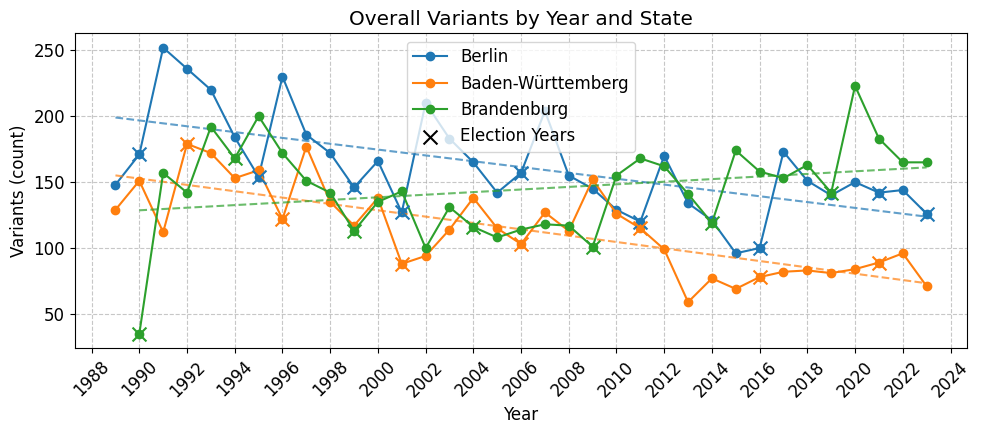

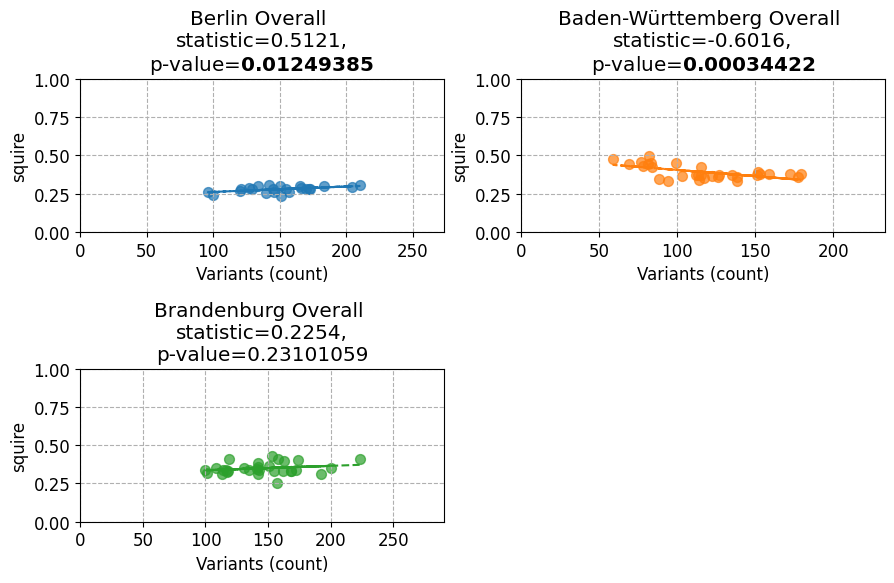

In [85]:
plot_fun_overall(performanceMeasureFunction)

### Per VTypL

#### Anfrage

,Bundesland,Variants
0,Berlin,96
1,Baden-Württemberg,121
2,Brandenburg,106


Mann-Whitney U test - Berlin vs Brandenburg - Variants MannwhitneyuResult(statistic=665.0, pvalue=0.40275237517101203)
Mann-Whitney U test - Berlin vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=767.5, pvalue=0.06884176301918235)
Mann-Whitney U test - Brandenburg vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=827.0, pvalue=0.005204176006244376)


,Berlin,Baden-Württemberg,Brandenburg
1989,18,9,nan
1990,16,7,3.000000
1991,16,8,15.000000
1992,19,20,15.000000
1993,16,12,15.000000
1994,19,10,16.000000
1995,14,12,13.000000
1996,17,15,11.000000
1997,16,7,12.000000
1998,19,9,12.000000


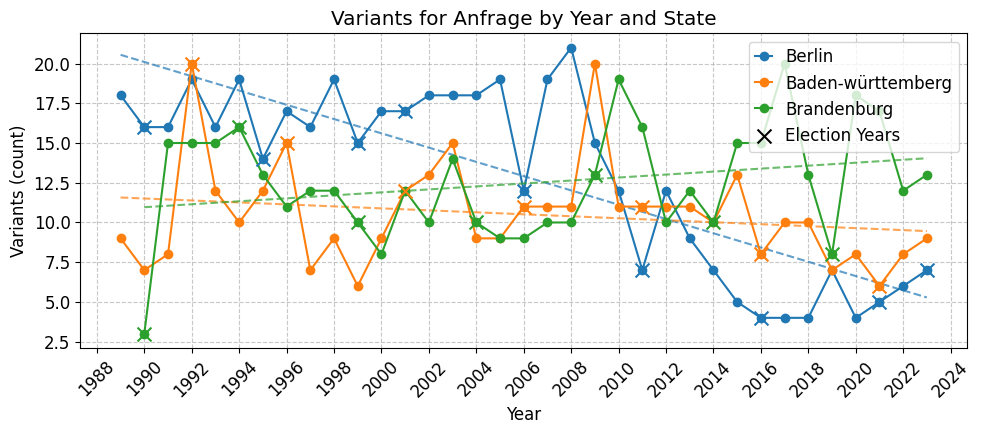

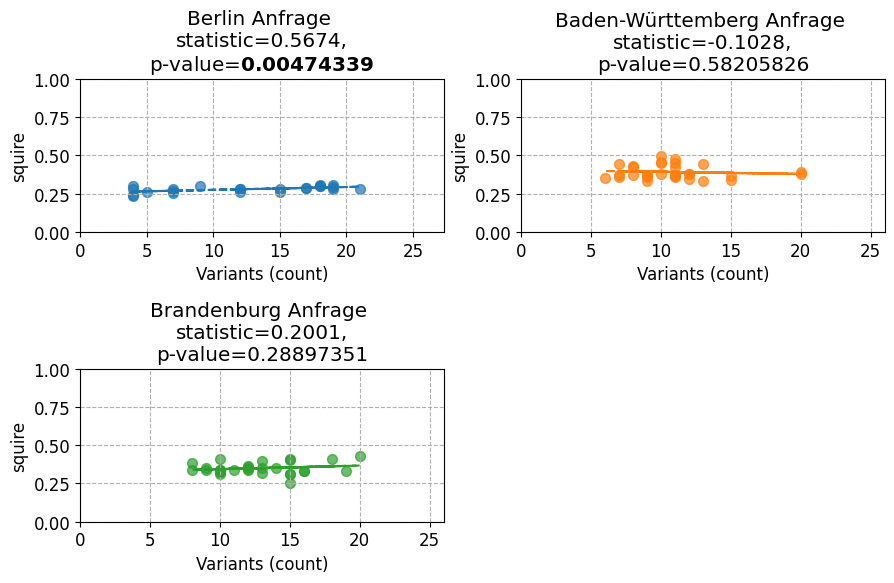

In [86]:
display_vtyp_results("Anfrage")

#### Antrag

,Bundesland,Variants
0,Berlin,932
1,Baden-Württemberg,494
2,Brandenburg,407


Mann-Whitney U test - Berlin vs Brandenburg - Variants MannwhitneyuResult(statistic=1097.0, pvalue=1.7320444740535858e-09)
Mann-Whitney U test - Berlin vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=1110.5, pvalue=5.04826690806352e-09)
Mann-Whitney U test - Brandenburg vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=599.5, pvalue=0.9616676336731576)


,Berlin,Baden-Württemberg,Brandenburg
1989,49,49,nan
1990,43,45,2.000000
1991,112,45,28.000000
1992,99,52,27.000000
1993,107,68,37.000000
1994,70,39,36.000000
1995,50,30,48.000000
1996,114,35,39.000000
1997,74,28,43.000000
1998,74,23,30.000000


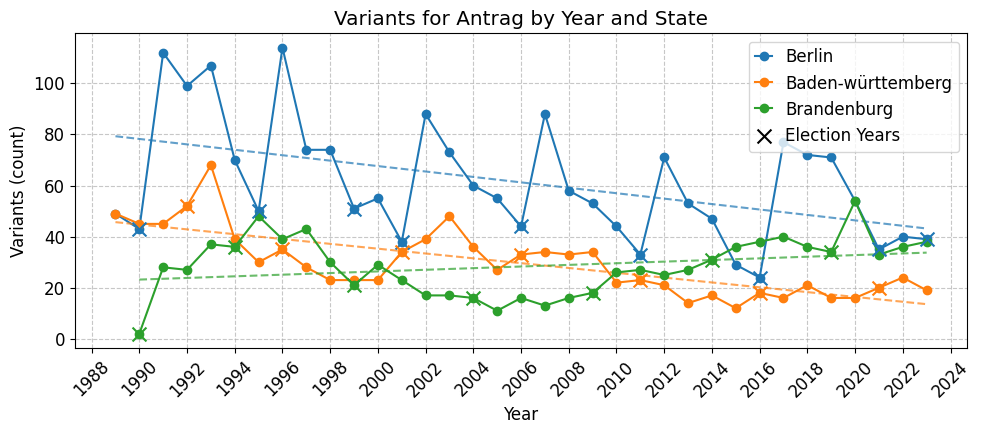

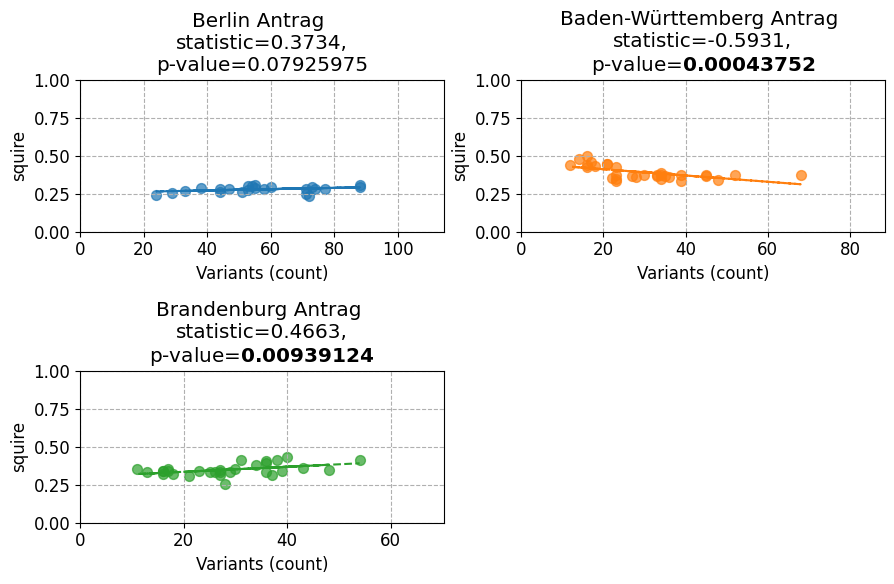

In [87]:
display_vtyp_results("Antrag")

#### Gesetzgebung

In [88]:
'''
# Modify the grouping by VTypL section
dataframes_by_VTypL = {}
dataframes_by_VTypL_by_year = {}
for bundesland in bundesLaender:
    dataframes_by_VTypL[bundesland] = {}
    dataframes_by_VTypL_by_year[bundesland] = {}
    
    # Apply the combination for VTypL
    df = dataframes[bundesland].copy()
    df['case:VTypL'] = df['case:VTypL'].apply(combine_gesetz_types)
    
    grouped = df.groupby(['case:VTypL'])
    for vtyp in grouped.groups.keys():
        dataframes_by_VTypL[bundesland][vtyp] = grouped.get_group(vtyp)
        dataframes_by_VTypL_by_year[bundesland][vtyp] = {}
        grouped_year = groupByYear(dataframes_by_VTypL[bundesland][vtyp])
        for year in grouped_year.groups.keys():
            dataframes_by_VTypL_by_year[bundesland][vtyp][year] = grouped_year.get_group(year)
'''

"\n# Modify the grouping by VTypL section\ndataframes_by_VTypL = {}\ndataframes_by_VTypL_by_year = {}\nfor bundesland in bundesLaender:\n    dataframes_by_VTypL[bundesland] = {}\n    dataframes_by_VTypL_by_year[bundesland] = {}\n    \n    # Apply the combination for VTypL\n    df = dataframes[bundesland].copy()\n    df['case:VTypL'] = df['case:VTypL'].apply(combine_gesetz_types)\n    \n    grouped = df.groupby(['case:VTypL'])\n    for vtyp in grouped.groups.keys():\n        dataframes_by_VTypL[bundesland][vtyp] = grouped.get_group(vtyp)\n        dataframes_by_VTypL_by_year[bundesland][vtyp] = {}\n        grouped_year = groupByYear(dataframes_by_VTypL[bundesland][vtyp])\n        for year in grouped_year.groups.keys():\n            dataframes_by_VTypL_by_year[bundesland][vtyp][year] = grouped_year.get_group(year)\n"

,Bundesland,Variants
0,Berlin,494
1,Baden-Württemberg,1056
2,Brandenburg,913


Mann-Whitney U test - Berlin vs Brandenburg - Variants MannwhitneyuResult(statistic=322.0, pvalue=0.0010640613968016758)
Mann-Whitney U test - Berlin vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=466.0, pvalue=0.08618760240533853)
Mann-Whitney U test - Brandenburg vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=613.5, pvalue=0.8288955824989285)


,Berlin,Baden-Württemberg,Brandenburg
1989,21,41,nan
1990,45,68,8.000000
1991,42,32,75.000000
1992,42,61,60.000000
1993,36,59,73.000000
1994,43,62,42.000000
1995,43,74,66.000000
1996,33,39,50.000000
1997,35,91,35.000000
1998,26,68,41.000000


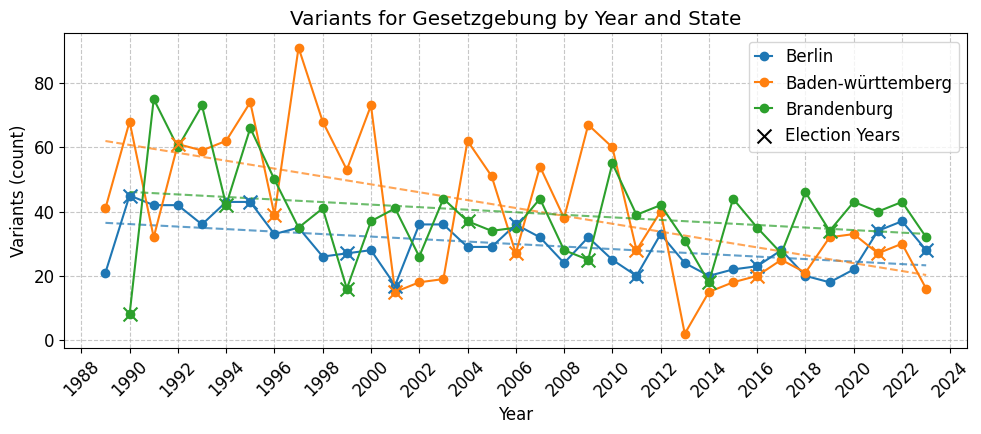

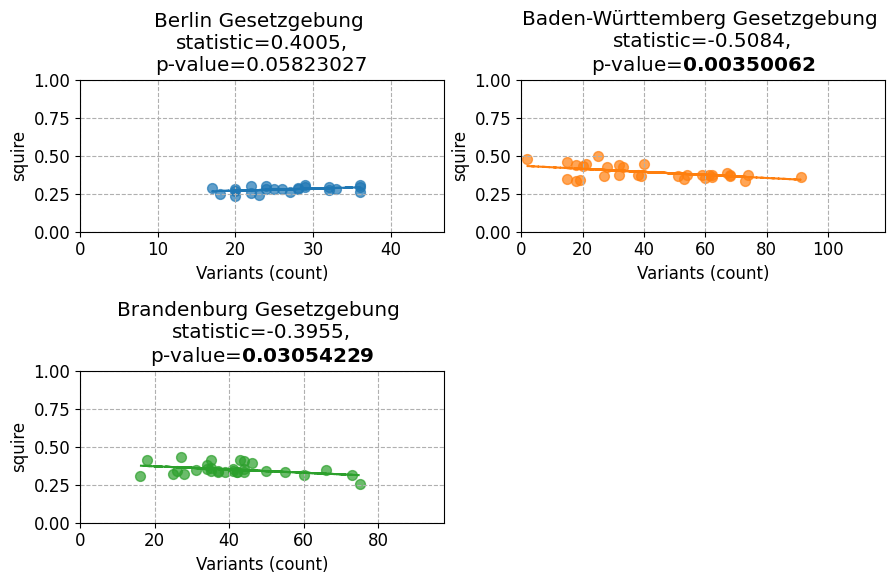

In [89]:
display_vtyp_results("Gesetzgebung")

### Debatte

,Bundesland,Variants
0,Berlin,178
1,Baden-Württemberg,23
2,Brandenburg,376


Mann-Whitney U test - Berlin vs Brandenburg - Variants MannwhitneyuResult(statistic=122.0, pvalue=1.3758024495566207e-08)
Mann-Whitney U test - Berlin vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=1225.0, pvalue=5.272120918739274e-13)
Mann-Whitney U test - Brandenburg vs Baden-Württemberg - Variants MannwhitneyuResult(statistic=1190.0, pvalue=7.842347703066508e-13)


,Berlin,Baden-Württemberg,Brandenburg
1989,22,2,nan
1990,31,3,15.000000
1991,28,3,28.000000
1992,26,5,23.000000
1993,17,6,43.000000
1994,13,5,39.000000
1995,12,4,42.000000
1996,26,3,34.000000
1997,21,4,40.000000
1998,20,5,30.000000


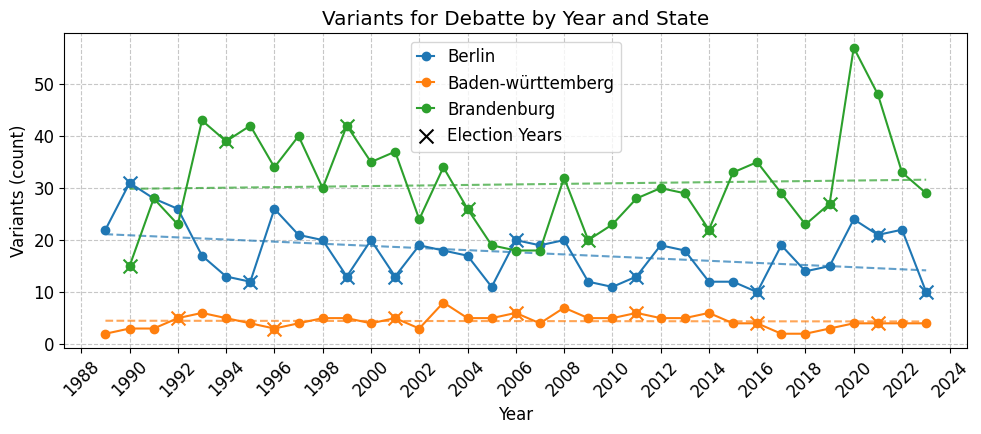

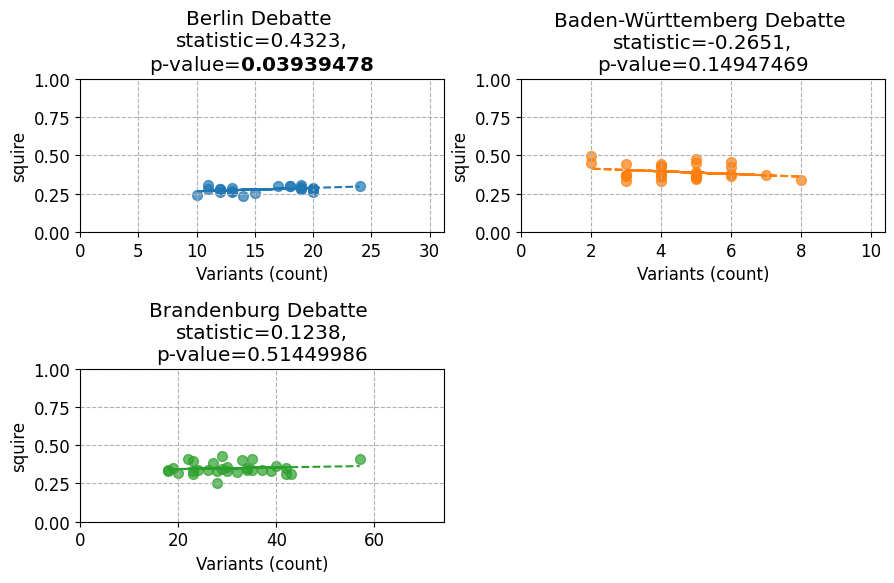

In [90]:
display_vtyp_results("Debatte")